In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
import os


In [3]:
df = pd.read_csv("C:/Users/ABHISHEKDARSANH/Downloads/ML_Portfolio/Credit_Card_Fraud_Detection/data/creditcard.csv")
df.head()
df.dtypes              

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [26]:
X = df.drop("Class",axis=1)
y = df["Class"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)


In [27]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled,y_train)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:,1]

print("AUC:",roc_auc_score(y_test,y_prob))
print(classification_report(y_test,y_pred))

AUC: 0.9605494455801453
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.63      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled,y_train_resampled = smote.fit_resample(X_train_scaled,y_train)

print("Before SMOTE:",sum(y_train))
print("After SMOTE:",sum(y_train_resampled))


Before SMOTE: 394
After SMOTE: 227451


In [30]:
log_reg_smote = LogisticRegression(max_iter=1000)

log_reg_smote.fit(X_train_resampled,y_train_resampled)

y_pred_smote = log_reg_smote.predict(X_test_scaled)
y_prob_smote = log_reg_smote.predict_proba(X_test_scaled)[:,1]

print("AUC:",roc_auc_score(y_test,y_prob_smote))
print(classification_report(y_test,y_pred_smote))

AUC: 0.9708434302252134
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators = 300,
    max_depth = None,
    min_samples_split =2,
    n_jobs = -1,
    class_weight = None

)
rf.fit(X_train_resampled,y_train_resampled)

y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:,1]

print("Random Forest AUC:",roc_auc_score(y_test,y_prob_rf))
print(classification_report(y_test,y_pred_rf))

Random Forest AUC: 0.9754497483433441
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.82      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [10]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators = 500,
    learning_rate = 0.05,
    max_depth = 6,
    sub_sample = 0.9,
    colsample_bytree = 0.9,
    reg_lambda = 1,
    random_state = 42,
    n_jobs = -1
)
xgb.fit(X_train_resampled,y_train_resampled)

y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:,1]

print("XGBoost AUC:",roc_auc_score(y_test,y_prob_xgb))
print(classification_report(y_test,y_pred_xgb))

C:\Users\ABHISHEKDARSANH\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [09:39:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUC: 0.9790362684184535
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.87      0.74        98

    accuracy                           1.00     56962
   macro avg       0.82      0.93      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [11]:
import numpy as np

sample_idx = np.random.choice(range(X_test_scaled.shape[0]),size=2000,replace=False)
X_shap = X_test_scaled[sample_idx]
X_shap_df = X_test.iloc[sample_idx]

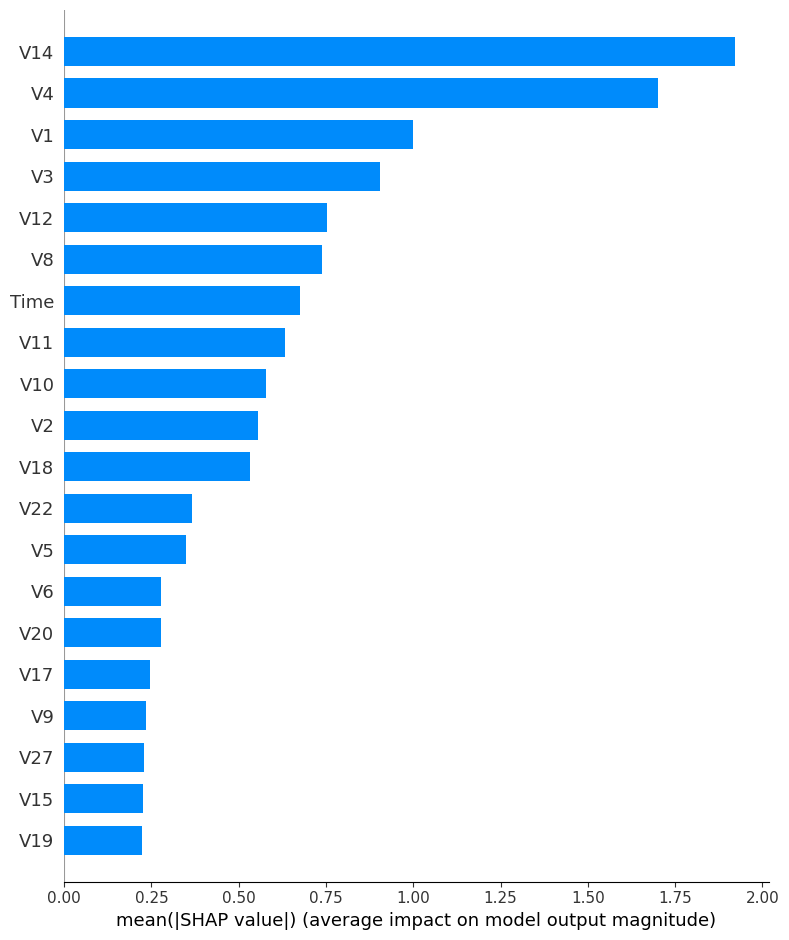

In [12]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb)

# Use ORIGINAL df values, not scaled
shap_values = explainer.shap_values(X_shap_df)

shap.summary_plot(shap_values, X_shap_df, plot_type="bar")


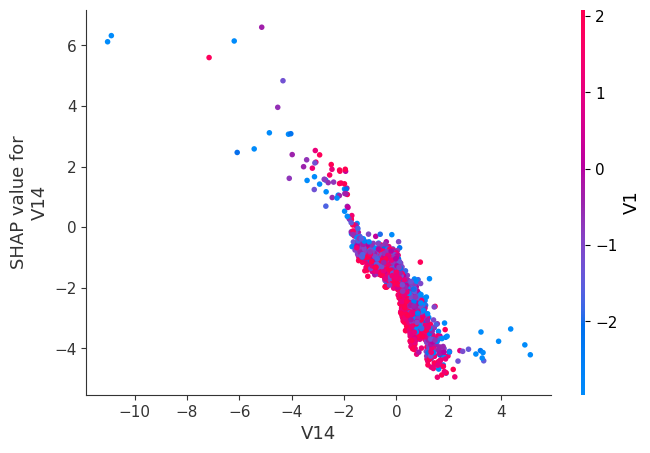

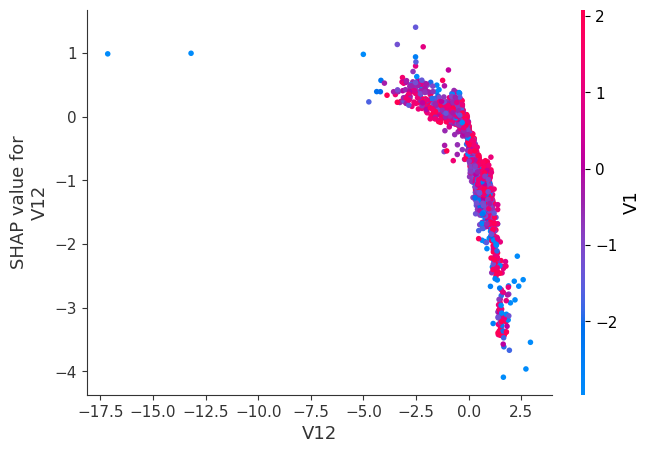

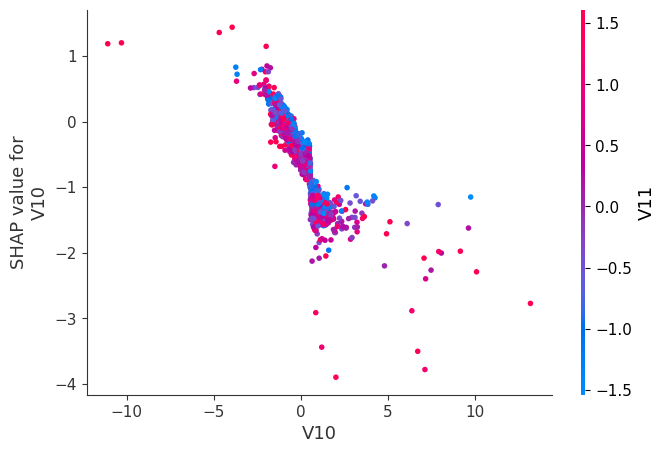

In [13]:
important_features = ["V14","V12","V10"]

for feature in important_features:
    shap.dependence_plot(feature,shap_values,X_shap_df,show=True)

In [14]:
fraud_indices_shap = X_shap_df[y_test.loc[X_shap_df.index] == 1].index
fraud_indices_shap[:10]


Index([124176, 150665, 111690, 623, 57615], dtype='int64')

<Figure size 2500x3000 with 0 Axes>

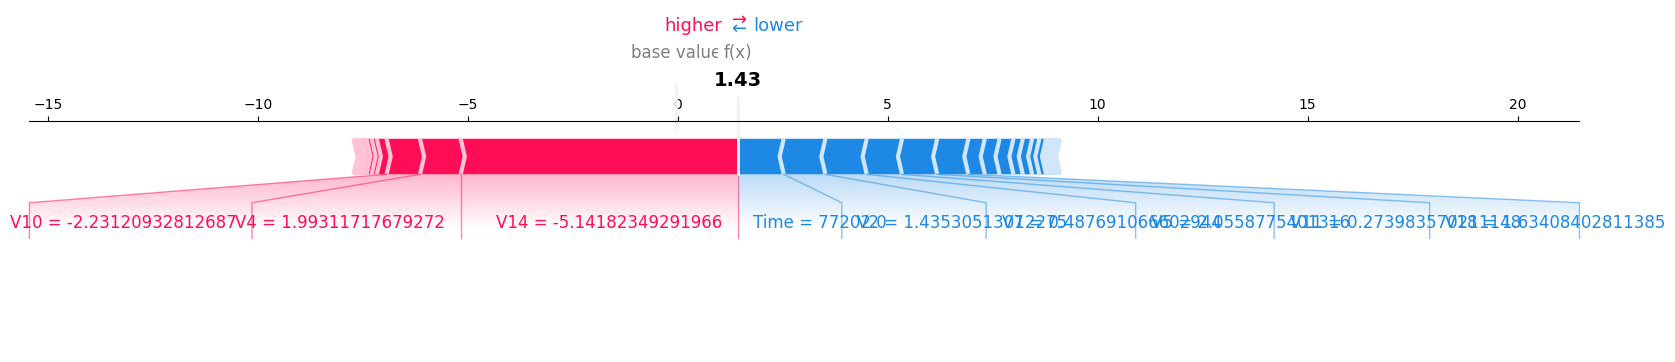

In [15]:
fraud_indices_shap = X_shap_df[y_test.loc[X_shap_df.index]==1].index
fraud_idx = fraud_indices_shap[0]

row_pos = X_shap_df.index.get_loc(fraud_idx)

import matplotlib.pyplot as plt
plt.figure(figsize=(25,30))

shap.force_plot(
    explainer.expected_value,
    shap_values[row_pos],
    X_shap_df.loc[fraud_idx],
    matplotlib =True
)
plt.show()



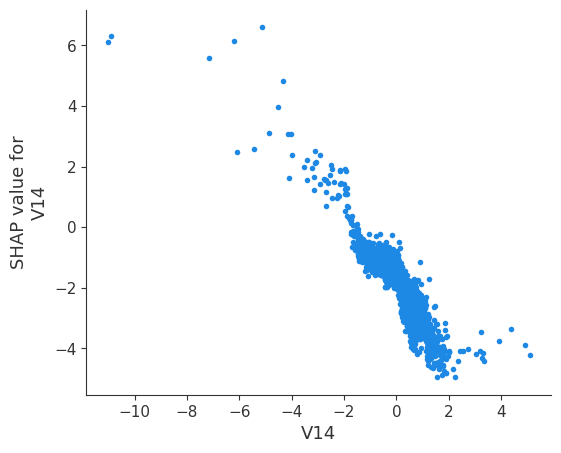

In [16]:
shap.dependence_plot(
    "V14",
    shap_values,
    X_shap_df,
    interaction_index = None
)

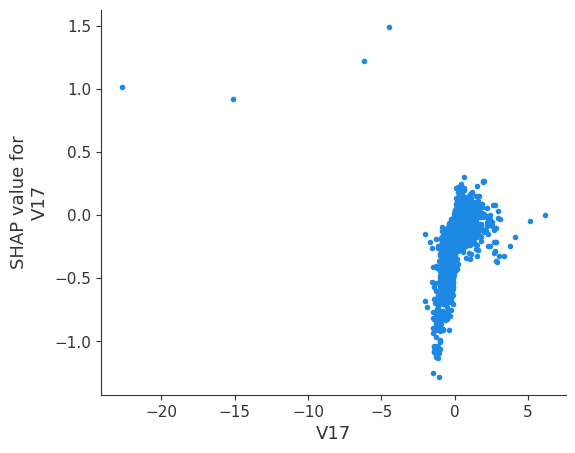

In [17]:
shap.dependence_plot(
    "V17",
    shap_values,
    X_shap_df,
    interaction_index = None
)

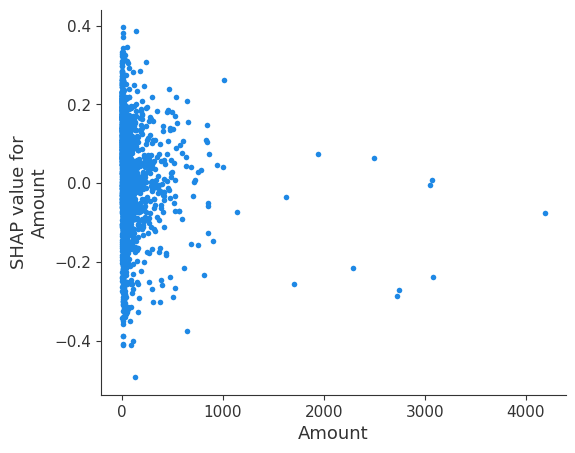

In [18]:
shap.dependence_plot(
    "Amount",
    shap_values,
    X_shap_df,
    interaction_index =None
)

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

results = []

# Logistic Regression (SMOTE)
results.append({
    "Model": "Logistic Regression (SMOTE)",
    "AUC": roc_auc_score(y_test, y_prob_smote),
    "Precision": precision_score(y_test, y_pred_smote),
    "Recall": recall_score(y_test, y_pred_smote),
    "F1": f1_score(y_test, y_pred_smote)
})

# Random Forest
results.append({
    "Model": "Random Forest",
    "AUC": roc_auc_score(y_test, y_prob_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf)
})

# XGBoost
results.append({
    "Model": "XGBoost",
    "AUC": roc_auc_score(y_test, y_prob_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb)
})


In [20]:
comparison_df = pd.DataFrame(results)
comparison_df


,Model,AUC,Precision,Recall,F1
0,Logistic Regression (SMOTE),0.970843,0.057803,0.918367,0.108761
1,Random Forest,0.975450,0.888889,0.816327,0.851064
2,XGBoost,0.979036,0.643939,0.867347,0.739130


Although XGBoost achieved the highest AUC, the Random Forest model provided the best balance between precision and recall, resulting in the highest F1-score for fraud detection. Given the high cost of false positives in real-world fraud systems, Random Forest was selected as the final production model.

In [21]:
import joblib
import json
import os

os.makedirs("artifacts", exist_ok=True)

joblib.dump(rf, "artifacts/fraud_rf_model.pkl")
joblib.dump(scaler, "artifacts/scaler.pkl")

with open("artifacts/feature_columns.json", "w") as f:
    json.dump(list(X.columns), f)

print("Artifacts saved successfully!")


Artifacts saved successfully!


In [22]:
import joblib
import json
import pandas as pd

model = joblib.load("artifacts/fraud_rf_model.pkl")
scaler = joblib.load("artifacts/scaler.pkl")

with open("artifacts/feature_columns.json","r") as f:
    feature_columns = json.load(f)

print("Artifacts loaded successfully")

Artifacts loaded successfully


In [23]:
def predict_fraud(input_dict,threshold=0.5):

    df = pd.DataFrame([input_dict])

    for col in feature_columns:
        if col not in feature_columns:
            df[col] = 0

    df = df[feature_columns]

    df_scaled = scaler.transform(df)

    fraud_prob = model.predict_proba(df_scaled)[0][1]

    fraud_label = int(fraud_prob >= threshold)

    return {
        "fraud_probability":round(float(fraud_prob),4),
        "fraud_prediction":fraud_label
    }

In [24]:
sample_input = X_test.iloc[0].to_dict()

prediction = predict_fraud(sample_input)
prediction

{'fraud_probability': 0.0, 'fraud_prediction': 0}

A Fraud case

In [25]:
fraud_sample = X_test[y_test == 1].iloc[0].to_dict()
predict_fraud(fraud_sample)


{'fraud_probability': 0.99, 'fraud_prediction': 1}